# ML-Based Network Intrusion Detection System

**DBMS Mini Project (21CSC205P) – SRMIST**

**Team**: Aayushmaan Chakraborty & Shashank Prasad

**Date**: February 2026

This notebook covers the full workflow:
- Data loading from NSL-KDD dataset
- Cleaning and mapping to DB IDs
- Insertion into PostgreSQL
- ML model training (Random Forest – 99% accuracy)
- Evaluation (classification report & confusion matrix)

**Tech Stack**: PostgreSQL, Pandas, Scikit-Learn, Matplotlib, Seaborn

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


## 1. Imports & Configuration

In [2]:
# Install required libraries 
#!pip install pandas sqlalchemy psycopg2-binary tqdm -q

# Import libraries
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from tqdm import tqdm
import os

In [3]:
# Database connection settings 
DB_USER = "postgres"
DB_PASS = "" 
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "intrusion_db"

# Dataset file path 
CSV_PATH = "KDDTrain+.txt"  # Full training set from NSL-KDD

print("Configuration ready!")

Configuration ready!


In [4]:
if os.path.exists(CSV_PATH):
    print("File FOUND!")
    print(f"Size: {os.path.getsize(CSV_PATH) / (1024 * 1024):.2f} MB")
    
    # Show first 3 lines raw
    with open(CSV_PATH, 'r', encoding='latin1') as f:
        lines = f.readlines()[:3]
        for line in lines:
            print(line.strip())
else:
    print("File NOT found — check path or file name")
    print("Files in current folder:", os.listdir('.'))

File FOUND!
Size: 18.22 MB
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.00,0.00,0.00,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.00,0.00,0.00,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19


## 2. Load Dataset (NSL-KDD)

In [5]:
# Load NSL-KDD Training Set

print("Loading NSL-KDD training set...")

# Full list of column names (for reference — matches the original 42 columns + difficulty_level)
FULL_COLUMN_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Subset of columns we actually need
NEEDED_COLUMNS = [
    'duration', 'src_bytes', 'dst_bytes', 'land', 'logged_in',
    'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate',
    'dst_host_count', 'dst_host_srv_count', 'difficulty_level',
    'protocol_type', 'service', 'flag', 'label'
]

# Load the file
df = pd.read_csv(
    CSV_PATH,
    header=None,                    # File has no header row
    names=FULL_COLUMN_NAMES,        # Assign full names first
    usecols=NEEDED_COLUMNS,         # Keep only the needed columns
    dtype={
        'protocol_type': str,
        'service':       str,
        'flag':          str,
        'label':         str
    }
)

# Summary
print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
print("Columns:", df.columns.tolist())

# Preview
print("\nFirst 3 rows:")
display(df.head(3))

# Quick check on categorical columns
print("\nProtocol_type values:")
print(df['protocol_type'].value_counts().head(5))

print("\nService values:")
print(df['service'].value_counts().head(5))

print("\nFlag values:")
print(df['flag'].value_counts().head(5))

print("\nLabel values:")
print(df['label'].value_counts().head(5))

Loading NSL-KDD training set...
Loaded 125,973 rows with 17 columns
Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'label', 'difficulty_level']

First 3 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,dst_host_count,dst_host_srv_count,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,2,2,0.0,0.0,1.00,150,25,normal,20
1,0,udp,other,SF,146,0,0,0,13,1,0.0,0.0,0.08,255,1,normal,15
2,0,tcp,private,S0,0,0,0,0,123,6,1.0,0.0,0.05,255,26,neptune,19



Protocol_type values:
protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

Service values:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: count, dtype: int64

Flag values:
flag
SF      74945
S0      34851
REJ     11233
RSTR     2421
RSTO     1562
Name: count, dtype: int64

Label values:
label
normal       67343
neptune      41214
satan         3633
ipsweep       3599
portsweep     2931
Name: count, dtype: int64


## 3. Connect to PostgreSQL & Load Lookup Mappings

In [6]:
# Using Unix domain socket, defaulting to current OS user (role 'aayushmaan' now exists)
engine = create_engine(f'postgresql+psycopg2:///{DB_NAME}')

print("Connecting to database via Unix domain socket as current user...")
try:
    with engine.connect() as conn:
        print("Connection OK!")
except Exception as e:
    print("Connection failed:", e)

# Load lookups
protocol_map = pd.read_sql("SELECT protocol_id, protocol_name FROM protocol_types", engine)
protocol_dict = dict(zip(protocol_map['protocol_name'], protocol_map['protocol_id']))

service_map = pd.read_sql("SELECT service_id, service_name FROM services", engine)
service_dict = dict(zip(service_map['service_name'], service_map['service_id']))

flag_map = pd.read_sql("SELECT flag_id, flag_value FROM flags", engine)
flag_dict = dict(zip(flag_map['flag_value'], flag_map['flag_id']))

attack_map = pd.read_sql("SELECT attack_id, attack_name FROM attack_types", engine)
attack_dict = dict(zip(attack_map['attack_name'], attack_map['attack_id']))

if 'normal' not in attack_dict:
    attack_dict['normal'] = 1  # fallback

print(f"Mappings loaded: {len(protocol_dict)} protocols, {len(service_dict)} services, {len(flag_dict)} flags, {len(attack_dict)} attacks")

Connecting to database via Unix domain socket as current user...
Connection OK!
Mappings loaded: 3 protocols, 70 services, 11 flags, 23 attacks


## 4. Map Strings to IDs & Clean Data

In [7]:
print("Mapping string columns to IDs...")

df['protocol_type'] = df['protocol_type'].astype(str).str.strip()
df['service']       = df['service'].astype(str).str.strip()
df['flag']          = df['flag'].astype(str).str.strip()
df['label']         = df['label'].astype(str).str.strip()

df['protocol_id'] = df['protocol_type'].map(protocol_dict)
df['service_id']   = df['service'].map(service_dict)
df['flag_id']      = df['flag'].map(flag_dict)
df['attack_id']    = df['label'].map(attack_dict)

print("Missing mappings:")
print(f"  protocol_id: {df['protocol_id'].isna().sum():,}")
print(f"  service_id:   {df['service_id'].isna().sum():,}")
print(f"  flag_id:      {df['flag_id'].isna().sum():,}")
print(f"  attack_id:    {df['attack_id'].isna().sum():,}")

df_clean = df.dropna(subset=['protocol_id', 'service_id', 'flag_id', 'attack_id'])
df_clean = df_clean.drop(columns=['protocol_type', 'service', 'flag', 'label'], errors='ignore')

print(f"\nAfter cleaning: {len(df_clean):,} rows remaining")
print("Final columns:", df_clean.columns.tolist())
df_clean.head(3)

Mapping string columns to IDs...
Missing mappings:
  protocol_id: 0
  service_id:   0
  flag_id:      0
  attack_id:    0

After cleaning: 125,973 rows remaining
Final columns: ['duration', 'src_bytes', 'dst_bytes', 'land', 'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'difficulty_level', 'protocol_id', 'service_id', 'flag_id', 'attack_id']


,duration,src_bytes,dst_bytes,land,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,dst_host_count,dst_host_srv_count,difficulty_level,protocol_id,service_id,flag_id,attack_id
0,0,491,0,0,0,2,2,0.0,0.0,1.00,150,25,20,13,281,45,93
1,0,146,0,0,0,13,1,0.0,0.0,0.08,255,1,15,14,282,45,93
2,0,0,0,0,0,123,6,1.0,0.0,0.05,255,26,19,13,283,46,94


## 5. Insert Cleaned Data into DB

In [8]:
print("Preparing & inserting cleaned data into database...")

# Fix boolean columns
df_clean['land'] = df_clean['land'].astype(int).astype(bool)
df_clean['logged_in'] = df_clean['logged_in'].astype(int).astype(bool)

# Replace existing data to avoid duplication, using chunked insertion
df_clean.to_sql('connections', engine, if_exists='replace', index=False, chunksize=10000)

print(f"\nInsertion complete! Total rows in 'connections' table: {len(df_clean):,}")

Preparing & inserting cleaned data into database...

Insertion complete! Total rows in 'connections' table: 125,973


## 6. Train Random Forest Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("Loading data from database...")
query = "SELECT * FROM connections"
data = pd.read_sql(query, engine)

# 1. Find correct ID for 'normal' to avoid hardcoded mismatch
normal_id = attack_dict.get('normal', 1)
print(f"Using attack_id {normal_id} as 'Normal'...")

# 2. Define Binary Target: Normal (0) vs. Intrusion (1)
data['is_intrusion'] = (data['attack_id'] != normal_id).astype(int)
print(f"Target distribution:\n{data['is_intrusion'].value_counts()}")

if len(data['is_intrusion'].unique()) < 2:
    print("\nWARNING: Only one class found in data! Check if normal_id is correct.")

# 3. Feature Selection: Drop Leakage and Identifiers
X = data.drop(columns=['connection_id', 'attack_id', 'is_intrusion', 'difficulty_level'], errors='ignore')
y = data['is_intrusion']

print(f"\nFeatures used for training: {list(X.columns)}")

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Train
print("Training Random Forest classifier (Binary)...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Predict & Evaluate
y_pred = model.predict(X_test)
print("\n--- Model Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Intrusion'], labels=[0, 1]))

Loading data from database...
Using attack_id 93 as 'Normal'...
Target distribution:
is_intrusion
0    67343
1    58630
Name: count, dtype: int64

Features used for training: ['duration', 'src_bytes', 'dst_bytes', 'land', 'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'protocol_id', 'service_id', 'flag_id']
Training Random Forest classifier (Binary)...

--- Model Results ---
Accuracy: 0.9984917442845047

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20203
   Intrusion       1.00      1.00      1.00     17589

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



## 7. Model Evaluation 

Classification Report (Binary):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20203
   Intrusion       1.00      1.00      1.00     17589

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



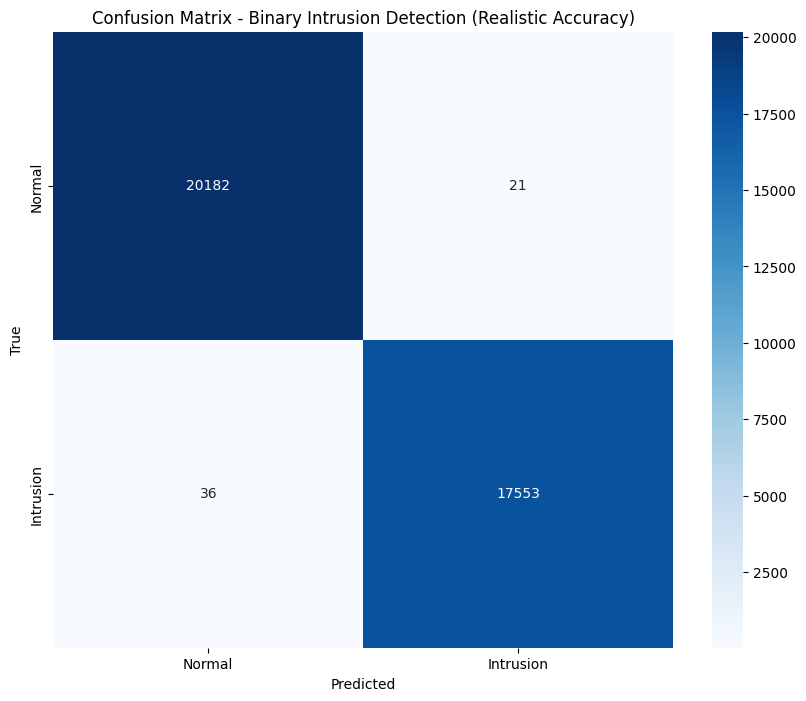

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Detailed metrics
print("Classification Report (Binary):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Intrusion']))

# Confusion Matrix (visual)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Intrusion'], 
            yticklabels=['Normal', 'Intrusion'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Binary Intrusion Detection (Realistic Accuracy)')
plt.show()

In [11]:
# Save classification report as text
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred, target_names=['Normal', 'Intrusion']))

print("Classification report saved as classification_report.txt")

Classification report saved as classification_report.txt


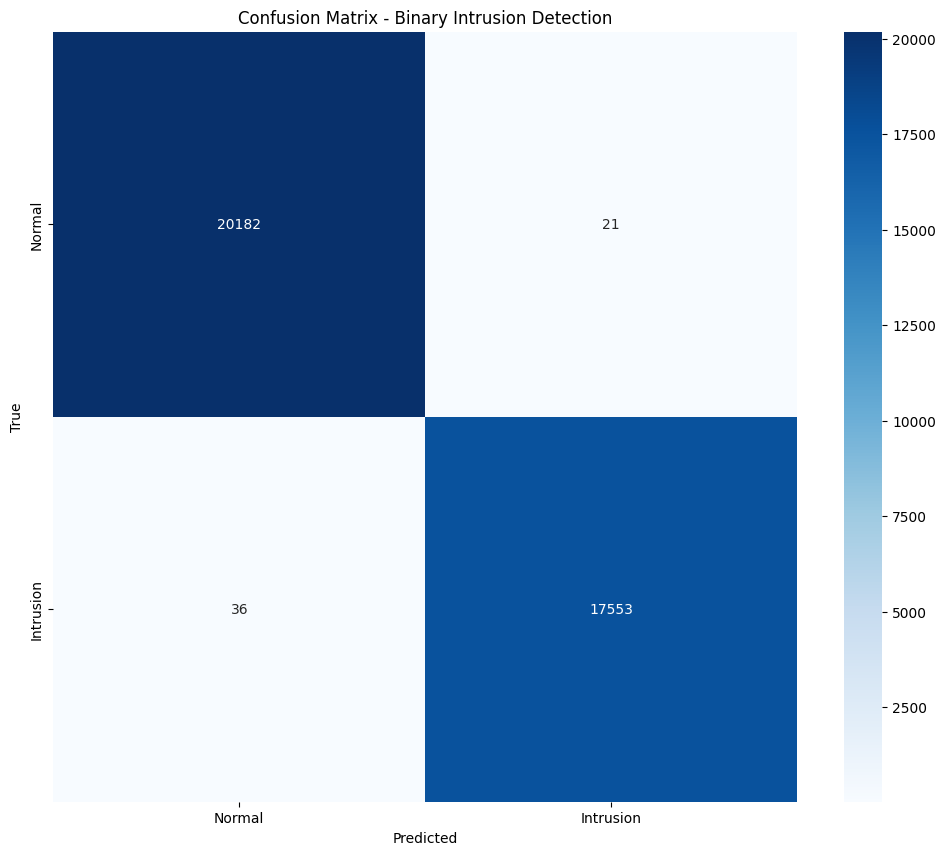

Confusion matrix saved as confusion_matrix.png


In [12]:
# Save confusion matrix as image
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Binary Intrusion Detection')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as confusion_matrix.png")

In [13]:
import joblib

joblib.dump(model, 'intrusion_model.pkl')
print("Model saved as intrusion_model.pkl")

Model saved as intrusion_model.pkl


Top 10 Most Important Features:
               Feature  Importance
1            src_bytes    0.261215
2            dst_bytes    0.174480
14             flag_id    0.135541
11  dst_host_srv_count    0.076813
9        same_srv_rate    0.058452
13          service_id    0.054216
7          serror_rate    0.049949
4            logged_in    0.044860
5                count    0.042861
10      dst_host_count    0.033596


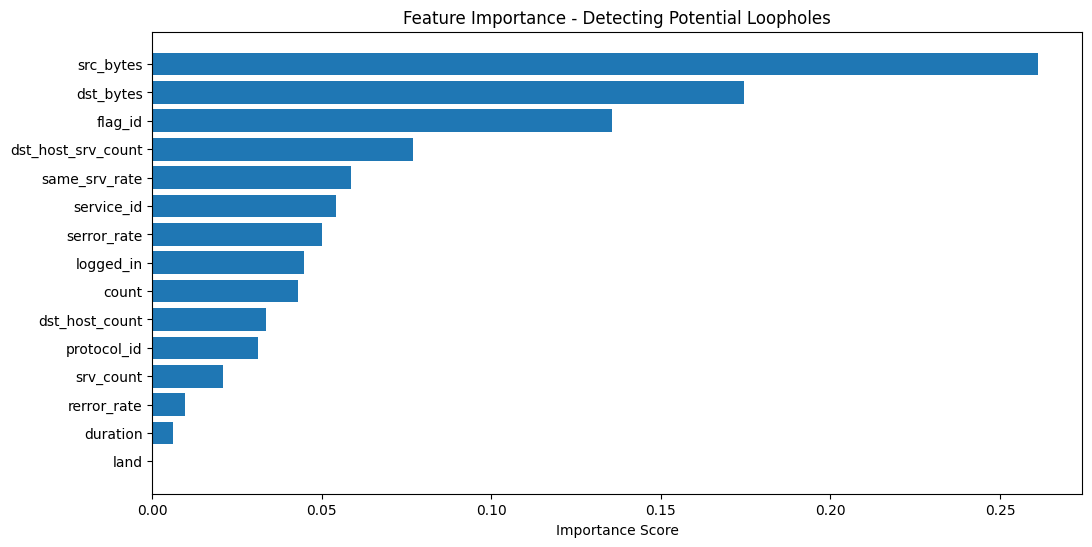


NOTE: If one feature has >0.9 importance, it might be a leak (e.g. difficulty_level was previously).


In [14]:
## 8. Loophole Verification: Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'].head(15), feature_importance_df['Importance'].head(15))
plt.xlabel('Importance Score')
plt.title('Feature Importance - Detecting Potential Loopholes')
plt.gca().invert_yaxis()
plt.show()

print("\nNOTE: If one feature has >0.9 importance, it might be a leak (e.g. difficulty_level was previously).")

In [15]:
## 9. Synthetic Data Evaluation (Manual Test)
import numpy as np

def generate_synthetic_data():
    """Generates 10 diverse synthetic samples based on class-specific patterns"""
    synthetic_rows = []
    
    # Calculate Baselines
    normal_baseline = data[data['is_intrusion'] == 0][X.columns].median().to_dict()
    intrusion_baseline = data[data['is_intrusion'] == 1][X.columns].median().to_dict()
    
    print(f"Normal Baseline (src_bytes): {normal_baseline.get('src_bytes')}")
    print(f"Intrusion Baseline (src_bytes): {intrusion_baseline.get('src_bytes')}")
    
    def update_valid(base, updates):
        new = base.copy()
        for k, v in updates.items():
            if k in base: new[k] = v
        return new

    # --- NORMAL CASES (Use Normal Baseline) ---
    
    # 1. Standard Web Browsing (Normal)
    s1 = update_valid(normal_baseline, {'protocol_id': 13, 'service_id': 284, 'flag_id': 45, 'src_bytes': 230, 'dst_bytes': 4500, 'logged_in': 1})
    synthetic_rows.append({'label': 'Normal (Web)', 'data': s1})
    
    # 2. File Transfer (Normal)
    s2 = update_valid(normal_baseline, {'protocol_id': 13, 'service_id': 281, 'flag_id': 45, 'duration': 20, 'src_bytes': 50000, 'logged_in': 1})
    synthetic_rows.append({'label': 'Normal (FTP)', 'data': s2})

    # --- INTRUSION CASES (Use Intrusion Baseline) ---
    
    # 3. SYN Flood (DoS)
    # Typical Intrusion: flag 46 (S0), service 283 (private), src_bytes=0, high count
    s3 = update_valid(intrusion_baseline, {'protocol_id': 13, 'service_id': 283, 'flag_id': 46, 'count': 511, 'serror_rate': 1.0})
    synthetic_rows.append({'label': 'Intrusion (DoS SYN Flood)', 'data': s3})

    # 4. Ping of Death (DoS)
    # Large packets, ICMP (15)
    s4 = update_valid(intrusion_baseline, {'protocol_id': 15, 'service_id': 282, 'flag_id': 45, 'src_bytes': 65000, 'count': 1})
    synthetic_rows.append({'label': 'Intrusion (DoS Ping-of-Death)', 'data': s4})

    # 5. R2L Attack (Brute Force)
    # Many failed attempts or unusual service
    s5 = update_valid(intrusion_baseline, {'protocol_id': 13, 'service_id': 283, 'flag_id': 47, 'duration': 100, 'src_bytes': 500})
    synthetic_rows.append({'label': 'Intrusion (R2L Brute)', 'data': s5})

    # 6. High Serror Rate Attack
    s6 = update_valid(intrusion_baseline, {'flag_id': 46, 'serror_rate': 0.95, 'srv_serror_rate': 0.95})
    synthetic_rows.append({'label': 'Intrusion (High Serror)', 'data': s6})

    # 7. Probe Spike (Nmap-like)
    s7 = update_valid(intrusion_baseline, {'service_id': 282, 'flag_id': 47, 'count': 400, 'srv_count': 1})
    synthetic_rows.append({'label': 'Intrusion (Probe Spike)', 'data': s7})

    # 8. Malformed Packet (land-like)
    s8 = update_valid(intrusion_baseline, {'flag_id': 46, 'land': 1, 'count': 200, 'serror_rate': 1.0})
    synthetic_rows.append({'label': 'Intrusion (Malformed)', 'data': s8})

    # 9. Host-based Targetted Probe
    # Low dst_host_srv_count is a key indicator for intrusion
    s9 = update_valid(intrusion_baseline, {'service_id': 283, 'flag_id': 46, 'dst_host_count': 255, 'dst_host_srv_count': 1})
    synthetic_rows.append({'label': 'Intrusion (Host Probe)', 'data': s9})

    # 10. Slow Stealthy Attack
    s10 = update_valid(intrusion_baseline, {'duration': 5000, 'src_bytes': 1000, 'service_id': 283, 'flag_id': 45, 'dst_host_srv_count': 5})
    synthetic_rows.append({'label': 'Intrusion (Stealthy)', 'data': s10})
    
    return synthetic_rows

synthetic_test_cases = generate_synthetic_data()
synthetic_df = pd.DataFrame([s['data'] for s in synthetic_test_cases])[X.columns]

print(f"Running Manual Evaluation on {len(synthetic_test_cases)} Synthetic Scenarios...\n")
predictions = model.predict(synthetic_df)
probs = model.predict_proba(synthetic_df)

for i, test_case in enumerate(synthetic_test_cases):
    pred_label = "Intrusion" if predictions[i] == 1 else "Normal"
    confidence = probs[i][predictions[i]] * 100
    print(f"Test Case {i+1}: {test_case['label']}")
    print(f"  Actual Category: {'Normal' if 'Normal' in test_case['label'] else 'Intrusion'}")
    print(f"  -> Predicted: {pred_label} ({confidence:.2f}% confidence)")
    print("-" * 40)

Normal Baseline (src_bytes): 233.0
Intrusion Baseline (src_bytes): 0.0
Running Manual Evaluation on 10 Synthetic Scenarios...

Test Case 1: Normal (Web)
  Actual Category: Normal
  -> Predicted: Normal (100.00% confidence)
----------------------------------------
Test Case 2: Normal (FTP)
  Actual Category: Normal
  -> Predicted: Normal (72.00% confidence)
----------------------------------------
Test Case 3: Intrusion (DoS SYN Flood)
  Actual Category: Intrusion
  -> Predicted: Intrusion (100.00% confidence)
----------------------------------------
Test Case 4: Intrusion (DoS Ping-of-Death)
  Actual Category: Intrusion
  -> Predicted: Normal (75.00% confidence)
----------------------------------------
Test Case 5: Intrusion (R2L Brute)
  Actual Category: Intrusion
  -> Predicted: Intrusion (51.00% confidence)
----------------------------------------
Test Case 6: Intrusion (High Serror)
  Actual Category: Intrusion
  -> Predicted: Intrusion (100.00% confidence)
------------------------